## Aliasing

In [1]:
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt

Set some parameters.

- `fs`: Sample rate (samples per second)
- `duration`: Duration of audio (seconds)
- `N`: number of samples

Calculate step sizes (intervals per unit).
- `dt`: time interval between each sample (seconds)
- `df`: frequency interval between each second (percent of samples in each second)

In [ ]:
fs = 1000 # sample rate

duration = 2
N = int(duration * fs)

# step size
dt = 1 / fs
df = fs / N

Create frequency and time vectors

In [149]:
f_arr = np.linspace(-fs/2, fs/2 - df, N) # frequency vector
t = np.linspace(0, duration - dt, N) # time vector

$sin$(2$\pi$ ft) calculates the full cycle of a frequency

In [150]:
tone = lambda f: np.sin(2 * np.pi * f * t)

Optionally, we can amplify our single tone with as many tones as we like.

In [151]:
# x = tone(261.628) # + tone(329.628) + tone(391.995) + tone(523.25) + tone(1046.50)
# x = tone(fs - 261.628)

to-do: loop this to show how the observed frequency varies based on aliasing.

in practice, solving these problems is usually bsaed on a known sampling rate and frequency rate.

Text(0, 0.5, 'Amplitude (~voltage)')

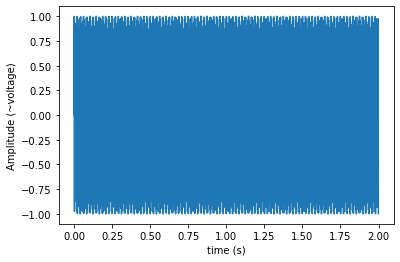

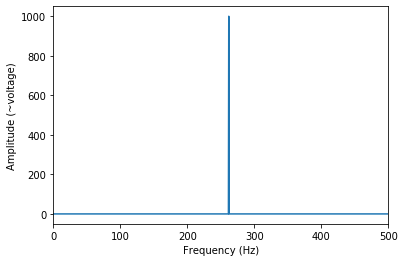

In [159]:
x = tone(261.628) 

# apply fourier transformation to x
X = np.fft.fftshift(np.fft.fft(x))

# plot waveform
plt.plot(t,x)
plt.xlabel('time (s)')
plt.ylabel('Amplitude (~voltage)')


# plot fourier transform
plt.figure()
plt.plot(f_arr, np.abs(X))
plt.xlim(0, fs/2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (~voltage)')

If aliasing is occurring then this will sound like the wrong note!  But you wouldn't notice if you didn't know any better.

In [160]:
# listen to data
sd.play(x, fs)